In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'seaborn'

In [2]:
df=pd.read_csv("weather_cleaned.csv")

In [3]:
import pandas as pd
import numpy as np
import torch

# Convert boolean columns to integers (0 and 1)
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Encode the city names as integers
df['city_idx'] = df['location_city'].astype('category').cat.codes  # Numeric index for each city
features = ['humidity_2m', 'dew_point_2m', 'precip', 'snowfall', 'snow_depth', 
            'msl_pressure', 'surface_pressure', 'cloud_cover_low', 'cloud_cover_mid',
            'cloud_cover_high', 'et0', 'vpd', 'wind_speed_10m', 'wind_dir_10m', 
            'soil_temp_0_7cm', 'soil_moisture_0_7cm', 'latitude', 'longitude'] + \
           [col for col in df.columns if col.startswith('weather_')]

target = 'temp_2m'
T = 5  # Number of timesteps
input_dim = len(features)

# Lists to hold training and testing data across all cities
X_train_list, y_train_list, city_train_list = [], [], []
X_test_list, y_test_list, city_test_list = [], [], []

# To compute normalization statistics
all_train_data = []

# Process each city independently
for city_id, city_data in df.groupby('city_idx'):
    city_data = city_data.sort_values(by='time').reset_index(drop=True)
    input_data = city_data[features].values
    targets = city_data[target].values
    
    # Determine train size for the current city
    N = len(input_data) - T  # Total number of sequences
    train_size = int(0.80 * N)
    
    # Split data for normalization calculation (only on training set)
    train_data = input_data[:train_size]
    all_train_data.append(train_data)  # Collect all training data for global normalization
    
    # Convert to torch tensors
    input_data_tensor = torch.tensor(input_data, dtype=torch.float32)
    target_tensor = torch.tensor(targets, dtype=torch.float32)
    
    # Initialize train and test tensors for this city
    X_train_city = torch.zeros((train_size, T, input_dim), dtype=torch.float32)
    y_train_city = torch.zeros((train_size, 1), dtype=torch.float32)
    X_test_city = torch.zeros((N - train_size, T, input_dim), dtype=torch.float32)
    y_test_city = torch.zeros((N - train_size, 1), dtype=torch.float32)
    
    # Prepare training sequences
    for t in range(train_size):
        X_train_city[t] = input_data_tensor[t:t + T]
        y_train_city[t] = target_tensor[t + T]
    
    # Prepare testing sequences
    for i in range(N - train_size):
        t = i + train_size
        X_test_city[i] = input_data_tensor[t:t + T]
        y_test_city[i] = target_tensor[t + T]
    
    # Prepare city indices for train and test
    city_train_city = torch.full((train_size,), city_id, dtype=torch.long)
    city_test_city = torch.full((N - train_size,), city_id, dtype=torch.long)
    
    # Append city-specific data to the main lists
    X_train_list.append(X_train_city)
    y_train_list.append(y_train_city)
    city_train_list.append(city_train_city)
    
    X_test_list.append(X_test_city)
    y_test_list.append(y_test_city)
    city_test_list.append(city_test_city)

# Concatenate all training data for normalization calculation
all_train_data = np.vstack(all_train_data)
train_mean = all_train_data.mean(axis=0)
train_std = all_train_data.std(axis=0)

# Concatenate all cities’ data to form the final tensors
X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
city_train = torch.cat(city_train_list, dim=0)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)
city_test = torch.cat(city_test_list, dim=0)

# Normalize X_train and X_test
train_mean_tensor = torch.tensor(train_mean, dtype=torch.float32)
train_std_tensor = torch.tensor(train_std, dtype=torch.float32)

# Normalize along the feature dimension (last dimension)
X_train = (X_train - train_mean_tensor) / train_std_tensor
X_test = (X_test - train_mean_tensor) / train_std_tensor

# Print shapes to confirm the results
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("city_train shape:", city_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("city_test shape:", city_test.shape)


X_train shape: torch.Size([868875, 5, 31])
y_train shape: torch.Size([868875, 1])
city_train shape: torch.Size([868875])
X_test shape: torch.Size([217220, 5, 31])
y_test shape: torch.Size([217220, 1])
city_test shape: torch.Size([217220])


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CNNModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim=16):
        super(CNNModelWithEmbedding, self).__init__()
        
        # Embedding for city index
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_dim + embedding_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 1)

        # Activation and pooling layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x, city_idx):
        # Get city embedding and repeat for each timestep
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        
        # Concatenate city embedding with each timestep in the sequence
        x = torch.cat([x, city_emb], dim=2)
        
        
        
        # Permute to (batch_size, input_dim, T) for Conv1d (expects channels-first format)
        x = x.permute(0, 2, 1)
        
        # Pass through convolutional layers with ReLU and selective pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)  # Pooling after the first conv layer to reduce sequence length moderately
        
        x = self.relu(self.conv2(x))
        
        
        x = self.relu(self.conv3(x))
        
       
        
        # Global average pooling over the remaining time steps
        x = x[:,:,-1]
        
        # Pass through fully connected layers with dropout
        x = self.dropout(self.fc1(x))
        x = self.relu(x)
        
        x = self.dropout(self.fc2(x))
        x = self.relu(x)
        
        x = self.output(x)
        
        return x

# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
num_cities = city_train.max().item() + 1  # Total number of unique cities
epochs = 1000
batch_size = 64
embedding_dim = 4  # Dimension of the embedding layer

# Initialize model, criterion, and optimizer
model = CNNModelWithEmbedding(input_dim=input_dim, num_cities=num_cities, embedding_dim=embedding_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
city_test_tensor = torch.tensor(city_test, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor, city_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor, city_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch, city_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch, city_batch)
        loss = loss_fn(output.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch, city_batch in test_loader:
            output = model(X_batch, city_batch)
            loss = loss_fn(output.squeeze(), y_batch.squeeze())
            val_loss += loss.item() * X_batch.size(0)

    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(test_loader.dataset)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
        # Save the model every 50 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"/home/research/a.naveen/denoise40/weather/cnn/epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, checkpoint_path)
        print(f"Model saved at {checkpoint_path}")


Using device: cuda


/tmp/ipykernel_1648711/1688949963.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
/tmp/ipykernel_1648711/1688949963.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_1648711/1688949963.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)
/tmp/ipykernel_1648711/1688949963.py:85: UserWarning: To copy const

Epoch 1/1000, Train Loss: 138.5998, Validation Loss: 5.5357
Epoch 2/1000, Train Loss: 74.5076, Validation Loss: 5.1230
Epoch 3/1000, Train Loss: 48.4255, Validation Loss: 3.9461
Epoch 4/1000, Train Loss: 31.9571, Validation Loss: 3.8089
Epoch 5/1000, Train Loss: 20.8519, Validation Loss: 3.0036
Epoch 6/1000, Train Loss: 17.7340, Validation Loss: 3.1280
Epoch 7/1000, Train Loss: 16.9302, Validation Loss: 3.2690
Epoch 8/1000, Train Loss: 16.6905, Validation Loss: 3.7488
Epoch 9/1000, Train Loss: 16.5388, Validation Loss: 3.1508
Epoch 10/1000, Train Loss: 16.5345, Validation Loss: 2.9932
Model saved at /home/research/a.naveen/denoise40/weather/cnn/epoch_10.pth
Epoch 11/1000, Train Loss: 16.3545, Validation Loss: 3.4580
Epoch 12/1000, Train Loss: 16.3389, Validation Loss: 2.9498
Epoch 13/1000, Train Loss: 16.2834, Validation Loss: 3.4345
Epoch 14/1000, Train Loss: 16.1579, Validation Loss: 2.8740
Epoch 15/1000, Train Loss: 16.1385, Validation Loss: 3.5200
Epoch 16/1000, Train Loss: 16.1330

KeyboardInterrupt: 

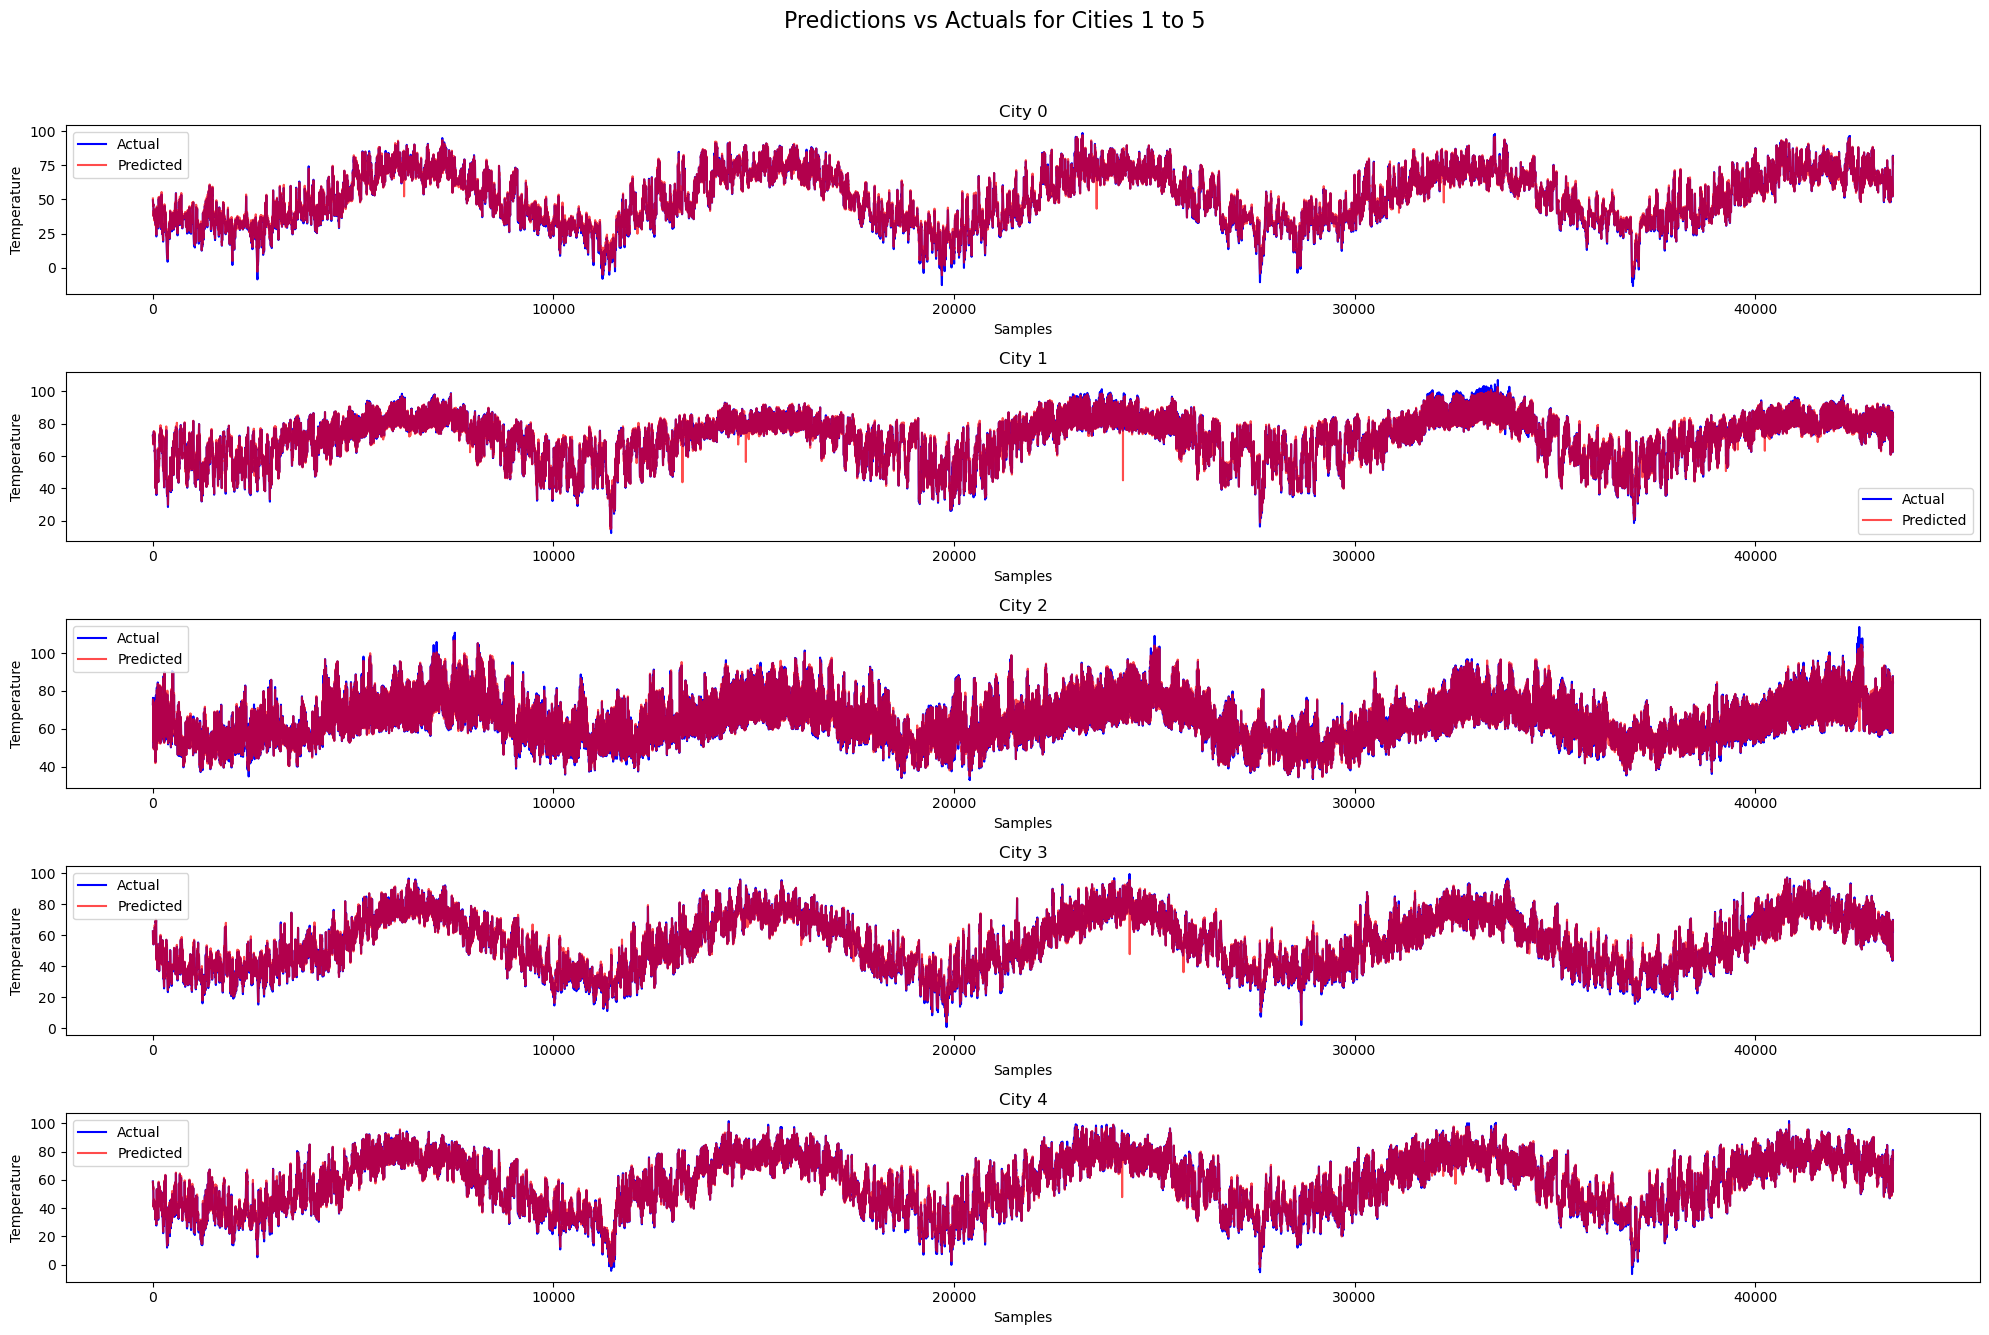

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set, grouped by city
model.eval()
predictions = []
actuals = []
city_indices = []

with torch.no_grad():
    for X_batch, y_batch, city_batch in test_loader:
        output = model(X_batch, city_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())
        city_indices.extend(city_batch.cpu().numpy())

# Convert lists to NumPy arrays
predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()
city_indices = np.array(city_indices)

# Get unique city indices for plotting city-wise
unique_cities = np.unique(city_indices)
num_cities = len(unique_cities)

# Plot predictions vs actual values for each city with subplots, 5 per figure
cities_per_fig = 5
num_figs = int(np.ceil(num_cities / cities_per_fig))

for fig_num in range(num_figs):
    start_idx = fig_num * cities_per_fig
    end_idx = min(start_idx + cities_per_fig, num_cities)
    cities_to_plot = unique_cities[start_idx:end_idx]
    
    fig, axes = plt.subplots(len(cities_to_plot), 1, figsize=(20, 14))
    fig.suptitle(f'Predictions vs Actuals for Cities {start_idx + 1} to {end_idx}', fontsize=16)
    
    if len(cities_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable if only one subplot

    for ax, city_id in zip(axes, cities_to_plot):
        city_mask = city_indices == city_id
        city_predictions = predictions[city_mask]
        city_actuals = actuals[city_mask]
        
        ax.plot(city_actuals, label='Actual', color='blue')
        ax.plot(city_predictions, label='Predicted', color='red', alpha=0.7)
        ax.set_title(f'City {city_id}')
        ax.set_xlabel('Samples')
        ax.set_ylabel('Temperature')
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE, MAE, and RMSE
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


NameError: name 'actuals' is not defined

In [22]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/2a/9d/d332ec76e2cc442fce98bc43a44e69d3c281e6b4ede6b6db2616dc6fbec6/scikit_learn-1.5.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 48.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 17.6 MB/s eta 0:00:00
ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device: '/project/cigserver1/export1/naveen/anaconda3/envs/afm/lib/python3.9/site-packages/joblib/compressor.py'

Note: you may need to restart the kernel to use updated packages.


In [26]:
!df -h


Filesystem                                           Size  Used Avail Use% Mounted on
devtmpfs                                             378G     0  378G   0% /dev
tmpfs                                                378G  5.8M  378G   1% /dev/shm
tmpfs                                                378G  4.0G  374G   2% /run
tmpfs                                                378G     0  378G   0% /sys/fs/cgroup
/dev/sda2                                             64G   44G   21G  69% /
/dev/nvme0n1p1                                       3.5T   25G  3.5T   1% /scratch
/dev/sda1                                            2.0G  437M  1.6G  22% /boot
/dev/sda5                                            373G  2.7G  370G   1% /tmp
nfs.seas.wustl.edu:/seaslab/compute                 1000G  606G  395G  61% /project/compute
nfs.seas.wustl.edu:/seaslab/home-compute              20T   12T  7.6T  62% /home/research
cigserver3.engr.wustl.edu:/export1/project           3.7T  2.8T  881G  77% /

In [25]:
import torch

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check CUDA availability and version
if torch.cuda.is_available():
    print("CUDA is available")
    print("CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available")


PyTorch version: 2.1.0
CUDA is available
CUDA version: 11.8
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
